In [2]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
sys.path.append(os.path.abspath(".."))  #TODO: MAKE THE SRC PACKAGE WORK
from src.training.new_optimised_train import train_lambdas_autoencoder, train_lambdas_cov
from src.evaluation.evaluate import Evaluation
from src.training.loss_functions import *
from src.preprocessing.preprocessing_functions import *

# Process Data

## 1. Load preprocessed images and tabular data
Several preprocessing steps were conducted on the raw images and tabular data - see notebook "data_preprocessing". 

In [46]:
images = np.load("../data/images/cleaned_images.npy")
tracks = np.load("../data/tracks/filtered_tracks.npy")
labels = np.load("../data/labels/filtered_y_train.npy")
labels_all = np.load("../data/labels/filtered_y_train_all_fates.npy")

print("Images shape: ", images.shape, "Tracks shape: ", tracks.shape, "Labels shape: ", labels.shape)

Images shape:  (1385, 1080, 2, 20, 20) Tracks shape:  (1385, 1080, 19) Labels shape:  (1385,)


### checking if data is the same

In [3]:
filtered_images_previous = np.load("/Users/inescunha/Documents/GitHub/interpretation/filtered_images.npy")
filtered_tracks_previous = np.load("/Users/inescunha/Documents/GitHub/interpretation/filtered_tracks.npy")
filtered_labels_previous = np.load("/Users/inescunha/Documents/GitHub/interpretation/filteresd_y_train.npy")

In [4]:
np.unique(np.nonzero(images[:,0,:,:] != filtered_images_previous)[0])

array([], dtype=int64)

## 2. Prepare for model training

### 1. FRET ratio calculation

In [47]:
fret_images = images[:,:,0,:,:] / images[:,:,1,:,:] 
fret_images = np.nan_to_num(fret_images, nan=0.0)

/var/folders/ds/_m8m03r135b5r67hc6xgtxt00000gn/T/ipykernel_25525/3830351353.py:1: RuntimeWarning: invalid value encountered in divide
  fret_images = images[:,:,0,:,:] / images[:,:,1,:,:]


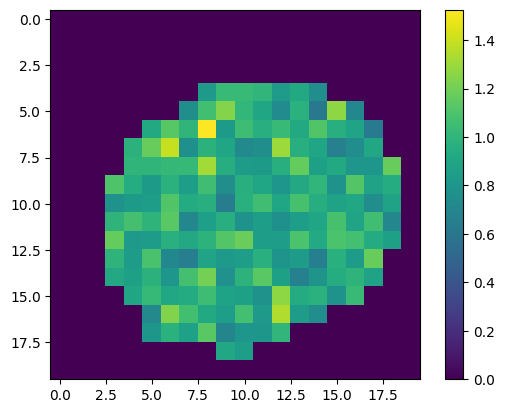

In [48]:
plt.imshow(fret_images[0,0,:,:])
plt.colorbar()

### 2. Normalise images frame-wise

In [49]:
norm_images = normalize_images_per_frame(fret_images)

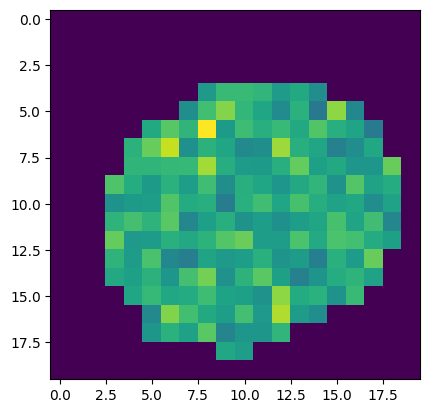

In [50]:
plt.imshow(norm_images[0,0,:,:])

### 3. Center cells

In [52]:
centered_images = center_cells(norm_images)

### 4. Train-test split

In [12]:
train_indexes, test_indexes = train_test_split(
        np.arange(len(labels)),
        test_size=0.2,
        stratify=labels,
        random_state=137
    )
    
train_images = centered_images[train_indexes]
train_labels = labels[train_indexes]
train_tracks = tracks[train_indexes]
test_images = centered_images[test_indexes]
test_labels = labels[test_indexes]
test_tracks = tracks[test_indexes]

NameError: name 'labels' is not defined

In [12]:
np.save("../data/images/train_images.npy", train_images)
np.save("../data/images/test_images.npy", test_images)
np.save("../data/labels/train_labels.npy", train_labels)
np.save("../data/labels/test_labels.npy", test_labels)
np.save("../data/tracks/train_tracks.npy", train_tracks)
np.save("../data/tracks/test_tracks.npy", test_tracks)

### 5. Data Augmentation

In [6]:
train_images = np.load("../data/images/train_images.npy")
test_images = np.load("../data/images/test_images.npy")
train_labels = np.load("../data/labels/train_labels.npy")
test_labels = np.load("../data/labels/test_labels.npy")
train_tracks = np.load("../data/tracks/train_tracks.npy")
test_tracks = np.load("../data/tracks/test_tracks.npy")

In [8]:
train_images.shape

(1108, 1080, 20, 20)

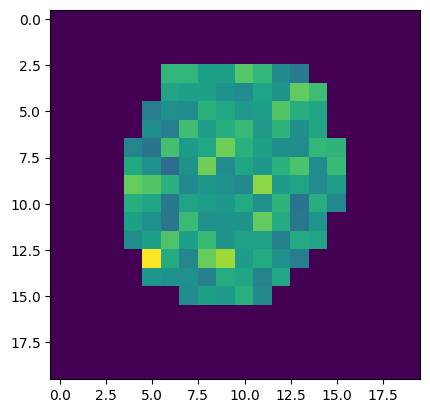

In [7]:
plt.imshow(train_images[0,0,:,:])

In [8]:
import numpy as np

def augment_dataset(cell_images, labels, augmentations, fate_0_label=0, fate_1_label=1, seed=42):
    """
    Augments a dataset of cell movies (cells, time, height, width), balances fate 0 and fate 1,
    and ensures reproducibility by setting a seed.

    Args:
        cell_images (numpy.ndarray): Array of shape (cells, time, height, width).
        labels (numpy.ndarray): 1D array of labels corresponding to cell fates.
        augmentations (function): Function that applies augmentations to an image sequence.
        fate_0_label (int): Label for fate 0 cells.
        fate_1_label (int): Label for fate 1 cells.
        seed (int): Random seed for reproducibility.

    Returns:
        tuple: Augmented and balanced (final_images, final_labels).
    """
    np.random.seed(seed)  # Ensure reproducibility

    # Separate fate 0 and fate 1 in the dataset
    fate_0_images = cell_images[labels == fate_0_label]
    fate_1_images = cell_images[labels == fate_1_label]

    # Apply augmentations to each time frame of each cell sequence
    augmented_fate_0 = np.concatenate([augmentations(movie) for movie in fate_0_images], axis=0)
    augmented_fate_1 = np.concatenate([augmentations(movie) for movie in fate_1_images], axis=0)

    # Combine original and augmented data
    fate_0_combined = np.concatenate([fate_0_images, augmented_fate_0], axis=0)
    fate_1_combined = np.concatenate([fate_1_images, augmented_fate_1], axis=0)

    # Balance fate 0 to match the number of fate 1 samples
    target_count = len(fate_1_combined)
    balanced_fate_0 = fate_0_combined[np.random.choice(
        len(fate_0_combined), size=target_count, replace=len(fate_0_combined) < target_count
    )]

    # Merge balanced datasets
    final_images = np.concatenate([balanced_fate_0, fate_1_combined], axis=0)
    final_labels = np.array([fate_0_label] * len(balanced_fate_0) + [fate_1_label] * len(fate_1_combined))

    # Shuffle data
    shuffle_indexes = np.random.permutation(len(final_labels))
    final_images, final_labels = final_images[shuffle_indexes], final_labels[shuffle_indexes]

    return final_images, final_labels

# **Augmentation function for time-series images**
def augmentations(movie):
    """
    Applies augmentations independently to each frame in a movie.

    Args:
        movie (numpy.ndarray): Array of shape (time, height, width).

    Returns:
        numpy.ndarray: Augmented images (new_axis is added to match input shape).
    """
    augmented_movies = []
    for frame in movie:
        augmented_frames = [
            np.flip(frame, axis=-1),  # Flip horizontally
            np.flip(frame, axis=-2),  # Flip vertically
            np.rot90(frame, k=1, axes=(-2, -1)),  # Rotate 90 degrees
            np.rot90(frame, k=2, axes=(-2, -1)),  # Rotate 180 degrees
            np.rot90(frame, k=3, axes=(-2, -1))  # Rotate 270 degrees
        ]
        augmented_movies.append(augmented_frames)

    return np.array(augmented_movies).transpose(1, 0, 2, 3)  # Shape (augments, time, height, width)


In [9]:
train_images_augmented, train_labels_augmented = augment_dataset(train_images, train_labels, augmentations)

In [15]:
train_images_augmented.shape

(2184, 1080, 20, 20)

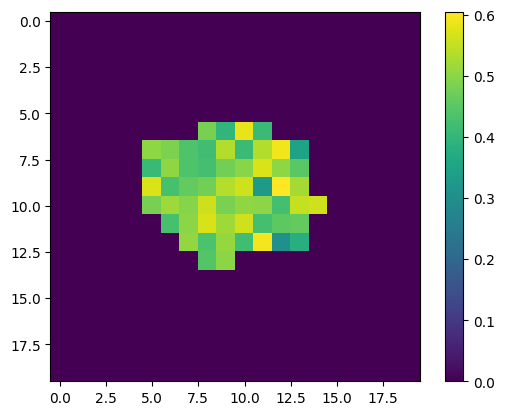

In [17]:
plt.imshow(train_images_augmented[200,0,:,:])
plt.colorbar()

In [4]:
train_images_augmented.shape, train_labels_augmented.shape

((2184, 1080, 20, 20), (2184,))

In [ ]:
# np.save("../data/images/train_images_augmented.npy", train_images_augmented)
# np.save("../data/labels/train_labels_augmented.npy", train_labels_augmented)

In [7]:
## FOR VISUALISATION PURPOSES ONLY ## - augment test set
test_images_augmented, test_labels_augmented = augment_dataset(test_images, test_labels, augmentations)

### 6. Stretch image intensities in a frame-wise way
This is done to do a scaling of the intensities in each cell, so that the minimum value is 0 (but keeping the same "relationship" between pixel values)

In [18]:
stretched_x_train, stretched_x_test = stretch_intensities_global(train_images_augmented, test_images)

In [8]:
stretched_x_train, stretched_x_test_augmented = stretch_intensities_global(train_images_augmented, test_images_augmented)

In [9]:
np.save("../data/images/stretched_x_test_augmented.npy", stretched_x_test_augmented)

In [22]:
np.save("../data/images/train_images_augmented_stretched.npy", stretched_x_train)
np.save("../data/images/test_images_augmented_stretched.npy", stretched_x_test)
np.save("../data/labels/train_labels_augmented.npy", train_labels_augmented)
np.save("../data/labels/test_labels.npy", test_labels)

print("Augmented images shape: ", stretched_x_train.shape, "Augmented labels shape: ", train_labels_augmented.shape, "Test images shape: ", stretched_x_test.shape, "Test labels shape: ", test_labels.shape, "Train tracks shape: ", train_tracks.shape, "Test tracks shape: ", test_tracks.shape)

Augmented images shape:  (2184, 1080, 20, 20) Augmented labels shape:  (2184,) Test images shape:  (277, 1080, 20, 20) Test labels shape:  (277,) Train tracks shape:  (1108, 1080, 19) Test tracks shape:  (277, 1080, 19)


In [21]:
stretched_x_train.min()

0.0

# Model Workflow - Training and Evaluation

In [3]:
train_images_augmented = np.load("../data/images/train_images_augmented_stretched.npy")
train_labels_augmented = np.load("../data/labels/train_labels_augmented.npy")
test_images = np.load("../data/images/test_images_augmented_stretched.npy")
train_labels = np.load("../data/labels/train_labels.npy")
test_labels = np.load("../data/labels/test_labels.npy")
train_tracks = np.load("../data/tracks/train_tracks.npy")
test_tracks = np.load("../data/tracks/test_tracks.npy")

In [4]:
train_images_augmented.shape

(2184, 1080, 20, 20)

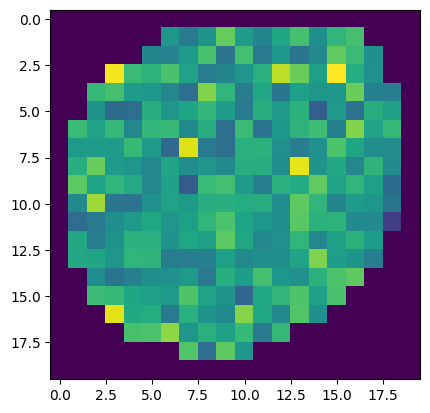

In [5]:
plt.imshow(train_images_augmented[0,0,:,:])

In [38]:
x_train = np.load('../data/centered_x_train.npy')

In [39]:
np.nonzero(x_train != train_images_augmented[:,0])

(array([   0,    0,    0, ..., 2183, 2183, 2183]),
 array([ 1,  1,  1, ..., 16, 16, 16]),
 array([ 6,  7,  8, ..., 10, 11, 12]))

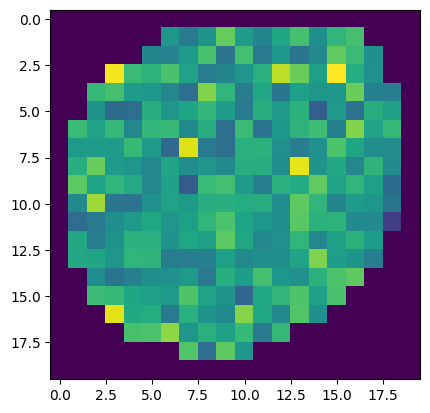

In [45]:
# find if there are full zero images

plt.imshow(train_images_augmented[0,0,:,:])

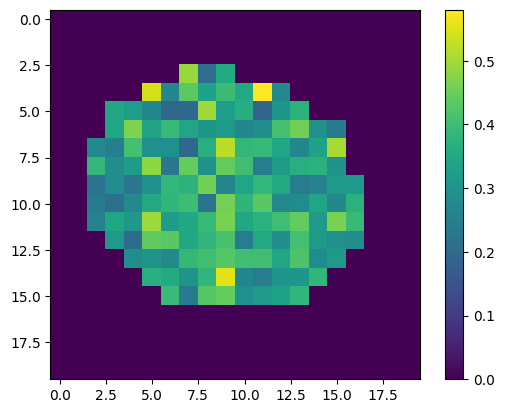

In [34]:
plt.imshow(x_train[100,:,:])
plt.colorbar()

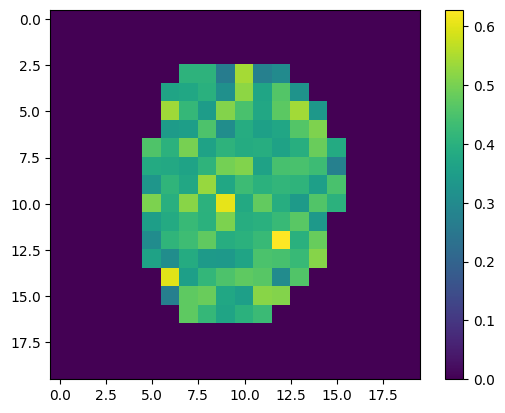

In [33]:
plt.imshow(train_images_augmented[100,0,:,:])
plt.colorbar()

In [28]:
x_train.shape, train_images_augmented.shape

((2184, 20, 20), (2184, 1080, 20, 20))

In [27]:
train_images_augmented.max()

1.0

## Tabular Data

In [10]:
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

config = {
    'batch_size': 30,
    'epochs': 50,
    'learning_rate': 0.001,
    'seed': 42,
}

In [11]:
### removing features that would bias the model decision (i.e., the fate of the cell, mitosis time, etc.)

train_tracks_features = train_tracks[:, :, 4:17 ] #[4,14,15,16]
test_tracks_features = test_tracks[:, :, 4:17]

print(train_tracks_features.shape)

(1108, 1080, 13)


### Simple MLP (No hidden layers)

In [12]:
def simple_mlp_classifier(latent_dim):
    return Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    ])

Using the first frame

In [13]:
frame = 0

class_weights = compute_class_weight('balanced', classes=np.unique(train_labels.flatten()), y=train_labels.flatten())
class_weights = dict(enumerate(class_weights))

tf.keras.utils.set_random_seed(config['seed'])

classifier = simple_mlp_classifier(latent_dim=train_tracks_features[:,frame,:].shape[1]) #[:, [3, 8]] 

# Train the classifier
classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config['learning_rate']), metrics=['accuracy'])
classifier.summary()

x_val_tracks, x_test_tracks, y_val_tracks, y_test_tracks = train_test_split(test_tracks_features[:,frame,:], test_labels, test_size=0.5, random_state=42) # 42 random state

history = classifier.fit(train_tracks_features[:,frame,:], train_labels, batch_size=config['batch_size'], epochs=config['epochs'], validation_data=(x_val_tracks, y_val_tracks), class_weight=class_weights) # 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80 (320.00 B)

 Trainable params: 54 (216.00 B)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6074 - loss: 0.7646 - val_accuracy: 0.1522 - val_loss: 3.1772
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - accuracy: 0.6041 - loss: 0.7584 - val_accuracy: 0.2826 - val_loss: 1.5749
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - accuracy: 0.6055 - loss: 0.7236 - val_accuracy: 0.4420 - val_loss: 1.0261
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - accuracy: 0.6054 - loss: 0.7412 - val_accuracy: 0.5000 - val_loss: 0.8256
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - accuracy: 0.6194 - loss: 0.6937 - val_accuracy: 0.5435 - val_loss: 0.7357
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - accuracy: 0.6358 - loss: 0.6450 - val_accuracy: 0.5652 - val_loss: 0.7005
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.5987 - loss: 0.6822 - val_accuracy: 0.5652 - val_loss: 0.6853
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.6060 - loss: 0.6884 - val_accuracy: 0.58

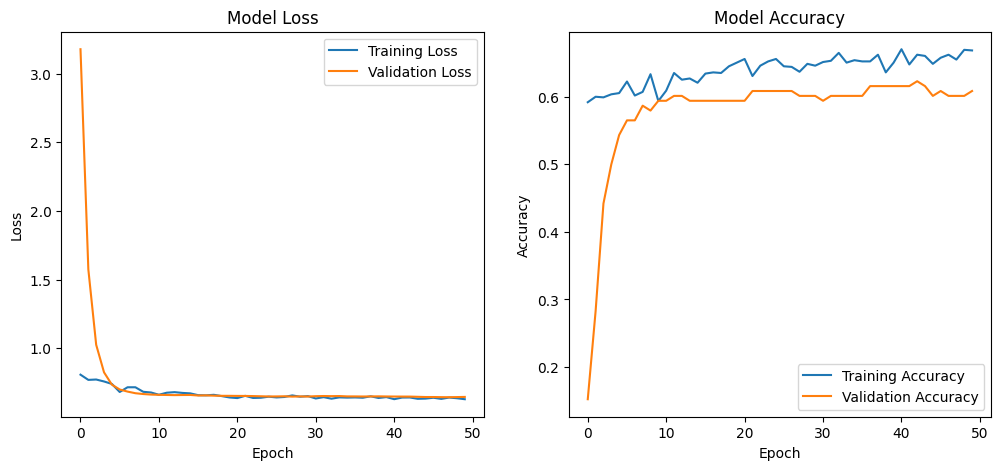

In [14]:
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[[0.65765766 0.34234234]
 [0.5        0.5       ]]


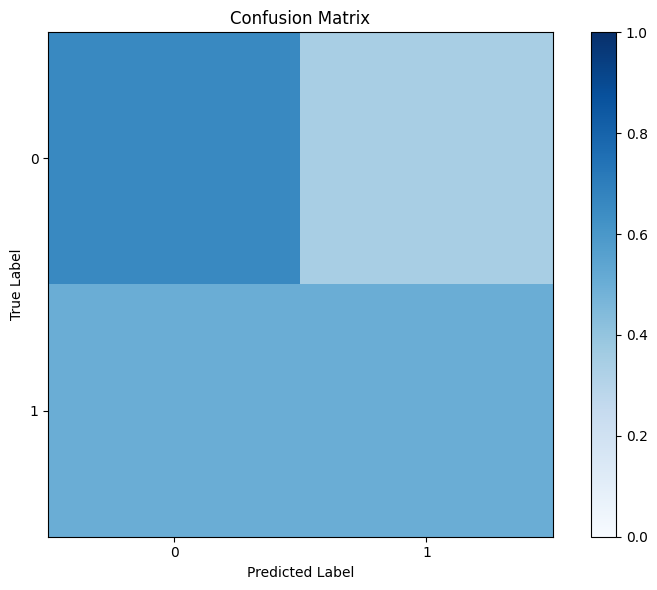

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

num_classes = len(np.unique(train_labels))
y_pred = classifier.predict(x_test_tracks)
# y_pred_classes = np.argmax(y_pred, axis=1)

threshold = 0.5
y_pred_classes = np.zeros_like(y_pred[:, 1])  # Initialize as class 0
y_pred_classes[y_pred[:, 1] > threshold] = 1  

# Calculate confusion matrix
cm = confusion_matrix(y_test_tracks, y_pred_classes)

class_sums = cm.sum(axis=1, keepdims=True)
conf_matrix_normalized = cm / class_sums

print(conf_matrix_normalized)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

### More Complex MLP 

In [16]:
def complex_mlp_classifier(latent_dim):
    return Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.Dropout(0.3),
        layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    ])

In [17]:
frame = 0

class_weights = compute_class_weight('balanced', classes=np.unique(train_labels.flatten()), y=train_labels.flatten())
class_weights = dict(enumerate(class_weights))

tf.keras.utils.set_random_seed(config['seed'])

classifier = complex_mlp_classifier(latent_dim=train_tracks_features[:,frame,:].shape[1]) #[:, [3, 8]] 

# Train the classifier
classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config['learning_rate']), metrics=['accuracy'])
classifier.summary()

x_val_tracks, x_test_tracks, y_val_tracks, y_test_tracks = train_test_split(test_tracks_features[:,frame,:], test_labels, test_size=0.5, random_state=42) # 42 random state

history = classifier.fit(train_tracks_features[:,frame,:], train_labels, batch_size=config['batch_size'], epochs=config['epochs'], validation_data=(x_val_tracks, y_val_tracks), class_weight=class_weights) # 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 430 (1.68 KB)

 Trainable params: 404 (1.58 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7217 - loss: 0.8490 - val_accuracy: 0.8623 - val_loss: 0.5306
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.6310 - loss: 0.7233 - val_accuracy: 0.5145 - val_loss: 0.6453
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - accuracy: 0.5542 - loss: 0.7207 - val_accuracy: 0.3913 - val_loss: 0.7161
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - accuracy: 0.4898 - loss: 0.6750 - val_accuracy: 0.3551 - val_loss: 0.7433
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.4931 - loss: 0.6711 - val_accuracy: 0.3551 - val_loss: 0.7445
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - accuracy: 0.4924 - loss: 0.6622 - val_accuracy: 0.4130 - val_loss: 0.7265
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - accuracy: 0.4875 - loss: 0.6584 - val_accuracy: 0.4348 - val_loss: 0.7130
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - accuracy: 0.4738 - loss: 0.6515 - val_accuracy: 0.46

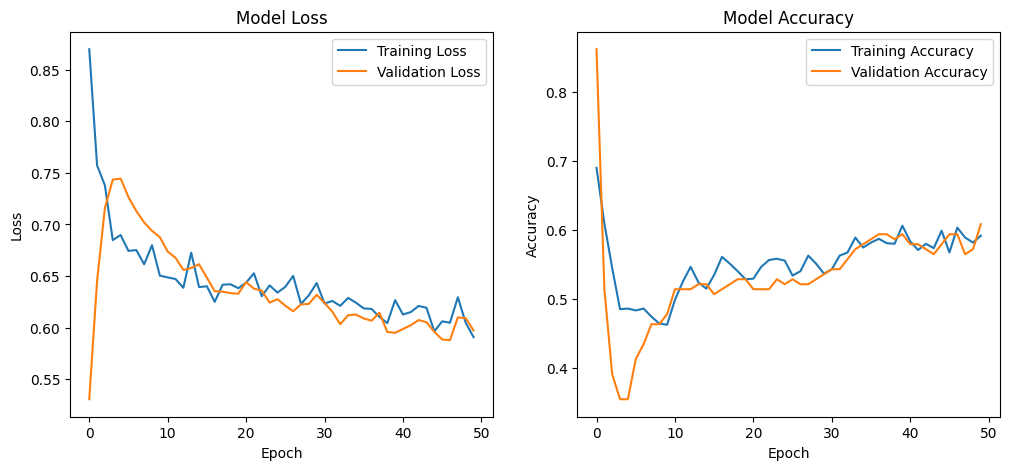

In [18]:
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[[0.55855856 0.44144144]
 [0.32142857 0.67857143]]
Precision:  0.6347349177330895


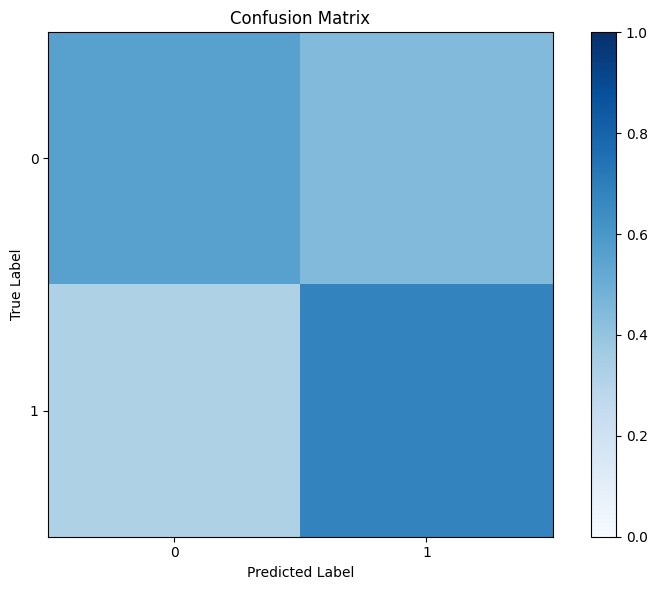

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

num_classes = len(np.unique(train_labels))
y_pred = classifier.predict(x_test_tracks)
# y_pred_classes = np.argmax(y_pred, axis=1)

threshold = 0.5
y_pred_classes = np.zeros_like(y_pred[:, 1])  # Initialize as class 0
y_pred_classes[y_pred[:, 1] > threshold] = 1  

# Calculate confusion matrix
cm = confusion_matrix(y_test_tracks, y_pred_classes)

class_sums = cm.sum(axis=1, keepdims=True)
conf_matrix_normalized = cm / class_sums

print(conf_matrix_normalized)

precision = conf_matrix_normalized[0,0] / (conf_matrix_normalized[0,0] + conf_matrix_normalized[1,0])
print("Precision: ", precision)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

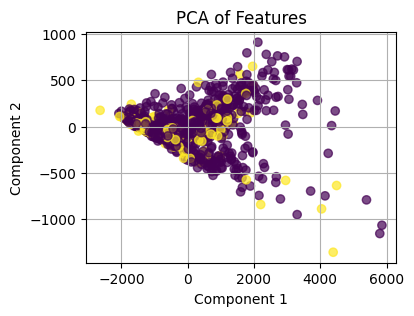

In [20]:
# Plot PCA of features to see if they are separable

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(train_tracks_features[:,frame,:])
X_pca = pca.transform(train_tracks_features[:,frame,:])

plt.figure(figsize=(4, 3))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=train_labels.flatten(), cmap='viridis', alpha=0.7)
#sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=train_labels.flatten())
plt.title('PCA of Features')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()

#### Temporal study

In [32]:
# normalise cell time clock 

train_tracks_features[30,1000:1079,0]

array([0.951053  , 0.94827026, 0.94068545, 0.92424554, 0.9496281 ,
       0.9703784 , 0.97906405, 0.9554697 , 0.94783634, 0.93334466,
       0.92589396, 0.9558917 , 0.89871794, 0.94242024, 0.9078279 ,
       0.8899528 , 0.97587824, 0.92142004, 0.95869654, 0.951546  ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [21]:
train_tracks_features.shape

(1108, 1080, 13)

In [25]:
def normalize_cell_time(data):
    """
    Normalize cell time by extracting feature values at 0%, 10%, ..., 100% 
    of each cell's lifetime.
    
    Parameters:
    - data: numpy array of shape (cells, time points, features)
      (assumes the first feature is used to determine lifetime)
    
    Returns:
    - normalized_data: numpy array of shape (cells, 11, features)
    """
    num_cells, num_timepoints, num_features = data.shape
    normalized_data = np.zeros((num_cells, 11, num_features))

    for i in range(num_cells):
        # Determine lifetime (number of nonzero values in the first feature)
        lifetime = np.count_nonzero(data[i, :, 0])

        if lifetime == 0:
            continue  # Skip cells that are all zero

        # Compute the indices corresponding to 0%, 10%, ..., 100% of the lifetime
        indices = np.round(np.linspace(0, lifetime - 1, 11)).astype(int)

        # Extract feature values at these indices
        normalized_data[i] = data[i, indices, :]

    return normalized_data


In [36]:
time_norm_train_track = normalize_cell_time(train_tracks_features)
time_norm_test_track = normalize_cell_time(test_tracks_features)

In [37]:
time_norm_train_track.shape, time_norm_test_track.shape

((1108, 11, 13), (277, 11, 13))

In [38]:
precisions = np.zeros((11, 1))

for i in range(11):
    frame = i
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels.flatten()), y=train_labels.flatten())
    class_weights = dict(enumerate(class_weights))

    tf.keras.utils.set_random_seed(config['seed'])

    classifier = complex_mlp_classifier(latent_dim=time_norm_train_track[:,frame,:].shape[1]) #[:, [3, 8]] 

    # Train the classifier
    classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config['learning_rate']), metrics=['accuracy'])
    classifier.summary()

    x_val_tracks, x_test_tracks, y_val_tracks, y_test_tracks = train_test_split(time_norm_test_track[:,frame,:], test_labels, test_size=0.5, random_state=42) # 42 random state

    history = classifier.fit(time_norm_train_track[:,frame,:], train_labels, batch_size=config['batch_size'], epochs=config['epochs'], validation_data=(x_val_tracks, y_val_tracks), class_weight=class_weights) 

    y_pred = classifier.predict(x_test_tracks)

    num_classes = len(np.unique(train_labels))
    threshold = 0.5
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test_tracks, y_pred_classes)

    class_sums = cm.sum(axis=1, keepdims=True)
    conf_matrix_normalized = cm / class_sums

    print(conf_matrix_normalized)

    precision = conf_matrix_normalized[0,0] / (conf_matrix_normalized[0,0] + conf_matrix_normalized[1,0])
    print("frame", frame, "Precision: ", precision)

    precisions[i] = precision


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_2           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 430 (1.68 KB)

 Trainable params: 404 (1.58 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7197 - loss: 0.8443 - val_accuracy: 0.8623 - val_loss: 0.4761
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - accuracy: 0.6145 - loss: 0.7330 - val_accuracy: 0.5580 - val_loss: 0.6146
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.5256 - loss: 0.7187 - val_accuracy: 0.3913 - val_loss: 0.6945
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.4610 - loss: 0.6792 - val_accuracy: 0.3623 - val_loss: 0.7215
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.4438 - loss: 0.6912 - val_accuracy: 0.3841 - val_loss: 0.7225
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - accuracy: 0.4584 - loss: 0.6728 - val_accuracy: 0.4420 - val_loss: 0.7106
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - accuracy: 0.4724 - loss: 0.6635 - val_accuracy: 0.4565 - val_loss: 0.7057
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - accuracy: 0.4846 - loss: 0.6613 - val_accuracy: 0.48

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_3           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 430 (1.68 KB)

 Trainable params: 404 (1.58 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7102 - loss: 0.8807 - val_accuracy: 0.8696 - val_loss: 0.4696
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.6120 - loss: 0.7516 - val_accuracy: 0.5507 - val_loss: 0.6206
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - accuracy: 0.5136 - loss: 0.7293 - val_accuracy: 0.3768 - val_loss: 0.7010
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.4584 - loss: 0.6822 - val_accuracy: 0.3406 - val_loss: 0.7283
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - accuracy: 0.4254 - loss: 0.7005 - val_accuracy: 0.3478 - val_loss: 0.7254
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.4694 - loss: 0.6816 - val_accuracy: 0.3623 - val_loss: 0.7095
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - accuracy: 0.4726 - loss: 0.6705 - val_accuracy: 0.4203 - val_loss: 0.7068
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.4759 - loss: 0.6727 - val_accuracy: 0.45

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_4           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 430 (1.68 KB)

 Trainable params: 404 (1.58 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7401 - loss: 0.8712 - val_accuracy: 0.8696 - val_loss: 0.4732
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6215 - loss: 0.7302 - val_accuracy: 0.5870 - val_loss: 0.6076
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.5590 - loss: 0.7115 - val_accuracy: 0.4565 - val_loss: 0.6763
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.4931 - loss: 0.6845 - val_accuracy: 0.3986 - val_loss: 0.7067
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.4778 - loss: 0.7040 - val_accuracy: 0.4203 - val_loss: 0.7065
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - accuracy: 0.5253 - loss: 0.6461 - val_accuracy: 0.4638 - val_loss: 0.6915
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.5034 - loss: 0.6781 - val_accuracy: 0.4710 - val_loss: 0.6896
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - accuracy: 0.5035 - loss: 0.6686 - val_accuracy: 0.4855

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_5           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 430 (1.68 KB)

 Trainable params: 404 (1.58 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7324 - loss: 0.8366 - val_accuracy: 0.8696 - val_loss: 0.4596
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - accuracy: 0.6384 - loss: 0.7212 - val_accuracy: 0.5435 - val_loss: 0.6070
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - accuracy: 0.5749 - loss: 0.6995 - val_accuracy: 0.4275 - val_loss: 0.6735
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.4770 - loss: 0.6792 - val_accuracy: 0.3913 - val_loss: 0.7042
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - accuracy: 0.4542 - loss: 0.6837 - val_accuracy: 0.4203 - val_loss: 0.7032
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - accuracy: 0.5179 - loss: 0.6376 - val_accuracy: 0.4928 - val_loss: 0.6862
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.4929 - loss: 0.6652 - val_accuracy: 0.5072 - val_loss: 0.6841
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - accuracy: 0.5050 - loss: 0.6587 - val_accuracy: 0.52

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_6           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 430 (1.68 KB)

 Trainable params: 404 (1.58 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7151 - loss: 0.8360 - val_accuracy: 0.8696 - val_loss: 0.4698
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.6104 - loss: 0.7232 - val_accuracy: 0.6449 - val_loss: 0.5904
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - accuracy: 0.5534 - loss: 0.7025 - val_accuracy: 0.5000 - val_loss: 0.6587
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - accuracy: 0.5012 - loss: 0.6850 - val_accuracy: 0.4493 - val_loss: 0.6936
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.4708 - loss: 0.6777 - val_accuracy: 0.4565 - val_loss: 0.6979
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.5031 - loss: 0.6360 - val_accuracy: 0.4783 - val_loss: 0.6845
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - accuracy: 0.4882 - loss: 0.6654 - val_accuracy: 0.4928 - val_loss: 0.6821
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.4725 - loss: 0.6663 - val_accuracy: 0.49

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_7           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 16)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 430 (1.68 KB)

 Trainable params: 404 (1.58 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7245 - loss: 0.8354 - val_accuracy: 0.8623 - val_loss: 0.4678
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.6407 - loss: 0.7342 - val_accuracy: 0.5797 - val_loss: 0.6102
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.5720 - loss: 0.6940 - val_accuracy: 0.4420 - val_loss: 0.6734
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - accuracy: 0.4974 - loss: 0.6802 - val_accuracy: 0.3696 - val_loss: 0.7019
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.4828 - loss: 0.6654 - val_accuracy: 0.4493 - val_loss: 0.6929
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.5136 - loss: 0.6423 - val_accuracy: 0.5072 - val_loss: 0.6788
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.4784 - loss: 0.6665 - val_accuracy: 0.5000 - val_loss: 0.6723
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.4977 - loss: 0.6616 - val_accuracy: 0.52

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_8           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 430 (1.68 KB)

 Trainable params: 404 (1.58 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7219 - loss: 0.8543 - val_accuracy: 0.8696 - val_loss: 0.4592
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.6480 - loss: 0.7259 - val_accuracy: 0.6014 - val_loss: 0.5806
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - accuracy: 0.5879 - loss: 0.6829 - val_accuracy: 0.4855 - val_loss: 0.6437
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - accuracy: 0.5143 - loss: 0.6657 - val_accuracy: 0.4565 - val_loss: 0.6714
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5130 - loss: 0.6659 - val_accuracy: 0.5000 - val_loss: 0.6688
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - accuracy: 0.5213 - loss: 0.6408 - val_accuracy: 0.5217 - val_loss: 0.6558
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - accuracy: 0.5174 - loss: 0.6651 - val_accuracy: 0.5217 - val_loss: 0.6528
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.5498 - loss: 0.6378 - val_accuracy: 0.5290

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_9           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 16)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 430 (1.68 KB)

 Trainable params: 404 (1.58 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7153 - loss: 0.8319 - val_accuracy: 0.8696 - val_loss: 0.4553
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.6593 - loss: 0.7213 - val_accuracy: 0.6087 - val_loss: 0.5896
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - accuracy: 0.5857 - loss: 0.6920 - val_accuracy: 0.5072 - val_loss: 0.6553
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.5212 - loss: 0.6629 - val_accuracy: 0.4493 - val_loss: 0.6831
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - accuracy: 0.5102 - loss: 0.6714 - val_accuracy: 0.5072 - val_loss: 0.6828
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.5143 - loss: 0.6434 - val_accuracy: 0.5290 - val_loss: 0.6701
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.5179 - loss: 0.6527 - val_accuracy: 0.5290 - val_loss: 0.6683
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - accuracy: 0.5059 - loss: 0.6600 - val_accuracy: 0.50

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_10          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 16)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 430 (1.68 KB)

 Trainable params: 404 (1.58 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7147 - loss: 0.8346 - val_accuracy: 0.8696 - val_loss: 0.4697
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6619 - loss: 0.7335 - val_accuracy: 0.5797 - val_loss: 0.5963
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - accuracy: 0.6041 - loss: 0.6893 - val_accuracy: 0.5290 - val_loss: 0.6520
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.5235 - loss: 0.6660 - val_accuracy: 0.5290 - val_loss: 0.6712
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.5072 - loss: 0.6774 - val_accuracy: 0.5290 - val_loss: 0.6768
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - accuracy: 0.5137 - loss: 0.6419 - val_accuracy: 0.5435 - val_loss: 0.6697
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.5082 - loss: 0.6536 - val_accuracy: 0.5507 - val_loss: 0.6608
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.5032 - loss: 0.6556 - val_accuracy: 0.5362

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_11          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 16)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 430 (1.68 KB)

 Trainable params: 404 (1.58 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7349 - loss: 0.8400 - val_accuracy: 0.8696 - val_loss: 0.5027
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.6659 - loss: 0.7435 - val_accuracy: 0.5290 - val_loss: 0.6305
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - accuracy: 0.5712 - loss: 0.7017 - val_accuracy: 0.4638 - val_loss: 0.6848
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.4672 - loss: 0.6921 - val_accuracy: 0.4130 - val_loss: 0.6939
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - accuracy: 0.4858 - loss: 0.6889 - val_accuracy: 0.4348 - val_loss: 0.6950
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.5093 - loss: 0.6522 - val_accuracy: 0.4638 - val_loss: 0.6884
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - accuracy: 0.4895 - loss: 0.6671 - val_accuracy: 0.4638 - val_loss: 0.6852
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.4802 - loss: 0.6673 - val_accuracy: 0.46

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_12          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 16)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 430 (1.68 KB)

 Trainable params: 404 (1.58 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7356 - loss: 0.8102 - val_accuracy: 0.8623 - val_loss: 0.4803
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - accuracy: 0.6751 - loss: 0.7317 - val_accuracy: 0.5435 - val_loss: 0.6120
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - accuracy: 0.5756 - loss: 0.6972 - val_accuracy: 0.4565 - val_loss: 0.6739
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4845 - loss: 0.6765 - val_accuracy: 0.4130 - val_loss: 0.6962
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - accuracy: 0.4846 - loss: 0.6768 - val_accuracy: 0.4420 - val_loss: 0.6941
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.5063 - loss: 0.6512 - val_accuracy: 0.4855 - val_loss: 0.6864
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - accuracy: 0.4940 - loss: 0.6631 - val_accuracy: 0.4783 - val_loss: 0.6833
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - accuracy: 0.5018 - loss: 0.6666 - val_accuracy: 0.4855

In [39]:
precisions

array([[0.60928   ],
       [0.70678016],
       [0.74905803],
       [0.75167785],
       [0.72727273],
       [0.72827417],
       [0.80722473],
       [0.83283133],
       [0.81313131],
       [0.85298013],
       [0.84533209]])

## Image Data

### Full CellFate Workflow 

#### 1. Train Adversarial Autoencoder (AAE)

#### 2. Train AAE with Contrastive loss and Covariance loss

#### 3. Classify with MLP 

#### 4. Evaluation 

#### 5. Temporal study

In [21]:
import numpy as np

def normalize_cell_time_images(images):
    """
    Normalize cell time by extracting images at 0%, 10%, ..., 100% 
    of each cell's lifetime.
    
    Parameters:
    - images: numpy array of shape (cells, time, height, width)
      (assumes a cell's lifetime is determined by nonzero pixel values)
    
    Returns:
    - normalized_images: numpy array of shape (cells, 11, height, width)
    """
    num_cells, num_timepoints, height, width = images.shape
    normalized_images = np.zeros((num_cells, 11, height, width))

    for i in range(num_cells):
        # Determine lifetime (number of nonzero frames)
        lifetime = np.count_nonzero(np.sum(images[i], axis=(1, 2)))  # Sum over spatial dims to check for zeros
        #print(lifetime)
        if lifetime == 0:
            continue  # Skip cells that are all zero

        # Compute the indices corresponding to 0%, 10%, ..., 100% of the lifetime
        indices = np.round(np.linspace(0, lifetime - 1, 11)).astype(int)

        # Extract images at these indices
        normalized_images[i] = images[i, indices, :, :]

    return normalized_images


In [48]:
train_images_augmented.shape

(2184, 1080, 20, 20)

In [ ]:
time_norm_train_images = normalize_cell_time_images(train_images_augmented)
time_norm_test_images = normalize_cell_time_images(test_images)


1079
1079
1079
1075
901
1080
1079
1079
1080
1002
127
1079
1080
1045
1079
240
957
1080
1080
139
1079
1079
34
392
0
524
1080
1072
1079
1075
1043
617
899
350
1077
266
0
34
1022
670
670
0
1079
1079
989
1080
288
1079
193
1080
161
30
1006
1077
1077
2
1079
1079
1080
436
1079
798
1079
1077
626
1079
1077
1079
1080
998
763
1079
289
160
1079
1079
1073
1080
1075
1079
249
908
1079
214
1079
993
1079
839
679
1079
1080
1079
1079
973
679
466
1079
568
1036
128
1079
1079
1079
545
1080
1080
835
1079
1079
1079
1080
374
1079
1080
1079
473
1079
1079
1079
1079
1079
1079
56
1077
1079
1079
1047
1080
152
1080
1079
128
263
1074
598
670
1079
319
281
256
179
670
1079
1075
1079
1080
953
1034
1079
937
1079
670
1012
119
1071
1079
670
1079
248
115
1079
1063
1079
1077
1080
1080
1011
516
670
1079
1079
1079
0
1079
1079
292
670
1077
967
882
1079
1079
801
1079
1075
1080
1079
762
1079
666
1079
670
42
1079
1079
1070
1077
1080
879
889
1060
1079
1080
1079
920
830
1079
34
1079
1079
143
615
1080
1060
1080
50
1079
1079
770
1079
15

In [66]:
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [ ]:
# np.save("../data/images/time_norm_train_images.npy", time_norm_train_images)
# np.save("../data/images/time_norm_test_images.npy", time_norm_test_images)

#### 6. Latent Space dimensionality study

### Only Adversarial Autoencoder

#### 1. Train Adversarial Autoencoder
With the same number of epochs and hyperparameters as before

#### 2. Evaluation 

### ImageNet classification